In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from icedef import statoil_arcticnet_data as sd
from icedef import plot, metocean
from importlib import reload
from astroML.stats import fit_bivariate_normal, bivariate_normal
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plot_dir = './plots/'

# BEACON

In [2]:
df_by_id = {}
for beacon_csv_filename in sd.beacon_csv_filenames:
    df = sd.get_beacon_df(sd.beacon_dir_path + beacon_csv_filename)
    beacon_id = df['BeaconID'][0]
    df_by_id[beacon_id] = df

In [3]:
latlons = []
labels = []

for beacon_id, df in df_by_id.items():
    lats, lons = df['Latitude'].values, df['Longitude'].values
    latlons.append([lats, lons])
    labels.append(beacon_id)

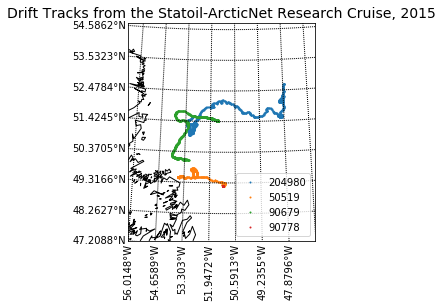

In [4]:
title = 'Drift Tracks from the Statoil-ArcticNet Research Cruise, 2015'
pads = 2
sizes = 2
map_kwargs = {'pads': pads}
scatter_kwargs = {}
kwargs ={'labels': labels, 'title': title, 'map_kwargs': map_kwargs, 'scatter_kwargs': scatter_kwargs}
fig, ax = plot.plot_track(*latlons, **kwargs)
fig.savefig(plot_dir + 'beacon_drift_tracks.png')

Initially, there were two iceberg's -- each with two beacon's attached. One iceberg, which we will call, "iceberg 1" had the beacon's: 50519 and 90778, the other, which we will call, "iceberg 2", had the beacon's 204980 and 90679. The beacon's onboard iceberg 1 were initially attached around 7 PM on April 23rd, 2015; however, after just one hour, beacon 90778 fell off leaving just beacon 50519 onboard iceberg 1 where it remained until around 2 PM on June 1st of that same year. Iceberg 2, on the other hand, has a more interesting life story. On April 24th, 2015 around 3 PM, both beacon's (204980 and 90679) were installed aboard iceberg 2. However, at around TODO, iceberg 2 split forming what we will call iceberg's 3 and 4 with beacon's 204980 and 90670; respectively. When this occurred, iceberg 2 was travelling roughly due West but after the split, iceberg 3 began moving Southwest and iceberg 4 went Northwest. Unfortunately, there is no data on the individual sizes of these bergs.

In [5]:
stats_df = pd.DataFrame(columns=['beacon_id', 'start_time', 'end_time', 'time_length', 
                                 'start_latitude', 'start_longitude',
                                 'end_latitude', 'end_longitude'])
for beacon_id, df in df_by_id.items():
    start_time = df['DataDate_UTC'][0]
    end_time = df['DataDate_UTC'][len(df['DataDate_UTC']) - 1]
    start_lat = df['Latitude'][0]
    end_lat = df['Latitude'][len(df['Latitude']) - 1]
    start_lon = df['Longitude'][0]
    end_lon = df['Longitude'][len(df['Longitude']) - 1]
    stats_df.loc[len(stats_df)] = [beacon_id, start_time, end_time, end_time - start_time, 
                                   start_lat, start_lon, end_lat, end_lon]

In [6]:
stats_df

,beacon_id,start_time,end_time,time_length,start_latitude,start_longitude,end_latitude,end_longitude
0,204980,2015-04-24 15:16:06,2015-06-13 09:33:42,49 days 18:17:36,51.45991,-51.55144,52.69404,-47.82604
1,50519,2015-04-23 18:48:37,2015-06-01 02:09:54,38 days 07:21:17,49.22403,-51.25820,49.46962,-53.58547
2,90679,2015-04-24 15:21:03,2015-05-25 01:20:03,30 days 09:59:00,51.46240,-51.55285,50.09155,-53.06512
3,90778,2015-04-23 18:53:57,2015-04-23 19:57:39,0 days 01:03:42,49.22347,-51.25890,49.22226,-51.24820


# Subset Info

In [7]:
start_time = np.datetime64(min(stats_df['start_time'])) - np.timedelta64(10, 'D')
end_time = np.datetime64(max(stats_df['end_time'])) + np.timedelta64(10, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

In [8]:
def subset_ds(ds, bounds_by_colname):
    for colname, bounds in bounds_by_colname.items():
        ds = ds.where((ds[colname] >= bounds[0]) & (ds[colname] <= bounds[1]), drop=True)
    return ds

# AVOS

In [9]:
avos_df = sd.get_avos_df()
avos_ds = sd.get_avos_ds()
avos_ds_subset = subset_ds(avos_ds, bounds_by_colname)
avos_ds_leg1 = subset_ds(avos_ds, {'time': (np.datetime64('2015-04-17'), np.datetime64('2015-05-05'))})

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:54: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


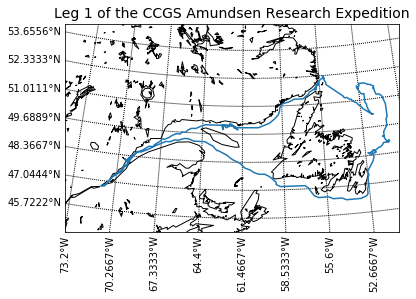

In [11]:
pads = 2
map_kwargs = {'pads': pads}
scatter_kwargs = {'linestyle': '-'}
title = 'Leg 1 of the CCGS Amundsen Research Expedition'
kwargs = {'map_kwargs': map_kwargs, 'title': title, 'line_plot': True}
fig, ax = plot.plot_track([avos_ds_leg1['latitude'].values, avos_ds_leg1['longitude'].values], **kwargs)
fig.savefig(plot_dir + 'amundsen_expedition_leg1.png')

In [10]:
# Note this takes really long to run
#plot.plot_track([avos_df['latitude'].values, avos_df['longitude'].values])

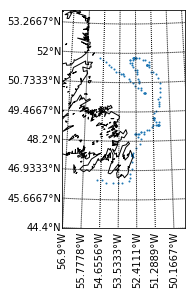

In [11]:
pads = 2
map_kwargs = {'pads': pads}
kwargs = {'map_kwargs': map_kwargs}
fig, ax = plot.plot_track([avos_ds_subset['latitude'].values, avos_ds_subset['longitude'].values], **kwargs)

Note: the ship went back to port after they placed the beacons. It then stayed in port from 2015-05-05 23:00 until 2015-07-10 00:00. 

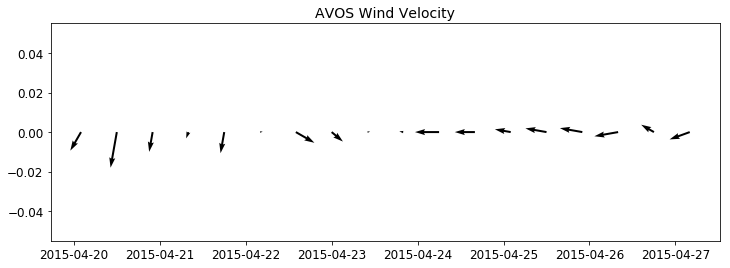

In [12]:
fig = plt.figure(figsize=(12, 4))
gap = 10
len_ = len(avos_ds_subset.time.values[::gap])
x = avos_ds_subset.time.values[::gap]
y = [0] * len_
u = avos_ds_subset.eastward_velocity.values[::gap]
v = avos_ds_subset.northward_velocity.values[::gap]
width = 3e-3
scale = 5e2
kwargs = {'width': width, 'scale': scale}
plt.quiver(x, y, u, v, **kwargs)
plt.title('AVOS Wind Velocity')
plt.show()
fig.savefig(plot_dir + 'avos_wind_velocity.png')

In [13]:
narr_atm = metocean.Atmosphere((avos_ds_subset.time.values[0], avos_ds_subset.time.values[-1]))

In [14]:
narr_atm_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
len_ = len(avos_ds_subset.time.values)
for i in range(len_):
    t = avos_ds_subset.time[i].values
    x = avos_ds_subset.longitude[i].values
    y = avos_ds_subset.latitude[i].values
    u = avos_ds_subset.eastward_velocity[i].values
    v = avos_ds_subset.northward_velocity[i].values
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = narr_atm.wind.interpolate((t, y, x))
                    narr_atm_df.loc[len(narr_atm_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

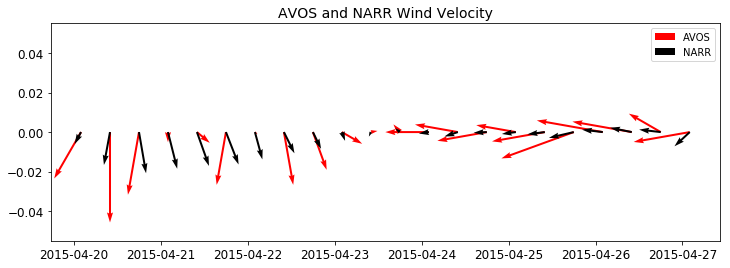

In [15]:
fig = plt.figure(figsize=(12, 4))
gap = 8
len_ = len(avos_ds_subset.time.values[::gap])
x = avos_ds_subset.time.values[::gap]
y = [0] * len_
u = avos_ds_subset.eastward_velocity.values[::gap]
v = avos_ds_subset.northward_velocity.values[::gap]
iu = narr_atm_df.iu.values[::gap]
iv = narr_atm_df.iv.values[::gap]
width = 3e-3
scale = 2e2
kwargs = {'width': width, 'scale': scale}
plt.quiver(x, y, u, v, color='red', label='AVOS', **kwargs)
plt.quiver(x, y, iu, iv, label='NARR', **kwargs)
plt.title('AVOS and NARR Wind Velocity')
plt.legend()
plt.show()
fig.savefig(plot_dir + 'avos_narr_wind_velocity.png')

# ADCP

In [16]:
adcp_ds = sd.get_adcp_ds()

In [17]:
adcp_ds_subset = subset_ds(adcp_ds, bounds_by_colname)

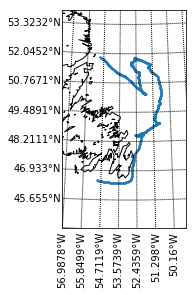

In [18]:
pads = 2
map_kwargs = {'pads': pads}
kwargs = {'map_kwargs': map_kwargs}
fig, ax = plot.plot_track([adcp_ds_subset.latitude.values, adcp_ds_subset.longitude.values], **kwargs)

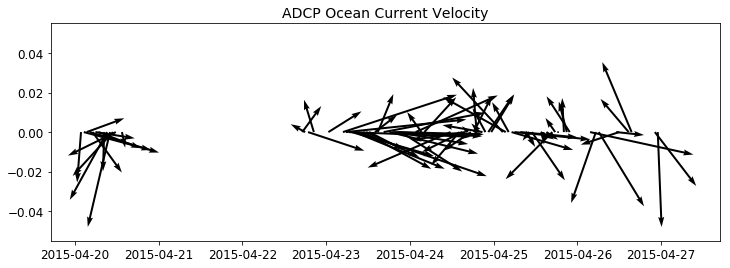

In [19]:
fig = plt.figure(figsize=(12, 4))
gap = 10
len_ = len(adcp_ds_subset.time.values[::gap])
x = adcp_ds_subset.time.values[::gap]
y = [0] * len_
u = adcp_ds_subset.eastward_velocity.values[::gap, 0] 
v = adcp_ds_subset.northward_velocity.values[::gap, 0]
width = 3e-3
scale = 2
kwargs = {'width': width, 'scale': scale}
plt.quiver(x, y, u, v, **kwargs)
plt.title('ADCP Ocean Current Velocity')
plt.show()
fig.savefig(plot_dir + 'adcp_current_velocity.png')

In [20]:
time_frame = adcp_ds_subset.time.values[0], adcp_ds_subset.time.values[-1]
ecmwf_ocean = metocean.Ocean(time_frame, model='ECMWF')
hycom_ocean = metocean.Ocean(time_frame, model='HYCOM')

In [21]:
ecmwf_ocean_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
hycom_ocean_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])

len_ = len(adcp_ds_subset.time.values)
for i in range(len_):
    t = adcp_ds_subset.time.values[i]
    x = adcp_ds_subset.longitude.values[i]
    y = adcp_ds_subset.latitude.values[i]
    u = adcp_ds_subset.eastward_velocity.values[i, 0]
    v = adcp_ds_subset.northward_velocity.values[i, 0]
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = ecmwf_ocean.current.interpolate((t, y, x))
                    ecmwf_ocean_df.loc[len(ecmwf_ocean_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]
                    iu, iv = hycom_ocean.current.interpolate((t, y, x))
                    hycom_ocean_df.loc[len(hycom_ocean_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

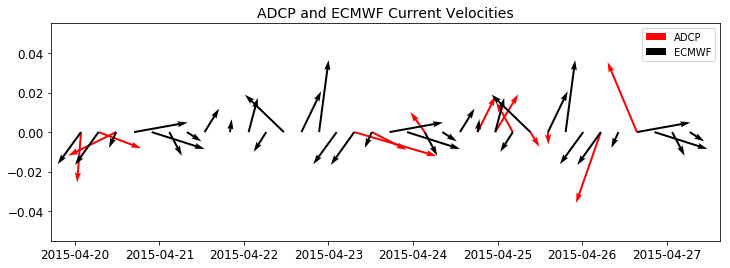

In [22]:
fig = plt.figure(figsize=(12, 4))
gap = 60
len_ = len(adcp_ds_subset.time.values[::gap])
x = adcp_ds_subset.time.values[::gap]
y = [0] * len_
u = adcp_ds_subset.eastward_velocity.values[::gap, 0]
v = adcp_ds_subset.northward_velocity.values[::gap, 0]

width = 3e-3
scale = 2
kwargs = {'width': width, 'scale': scale}

plt.quiver(x, y, u, v, color='red', label='ADCP', **kwargs)
iu = ecmwf_ocean_df.iu.values[::gap]
iv = ecmwf_ocean_df.iv.values[::gap]
plt.quiver(x, y, iu, iv, color='black', label='ECMWF', **kwargs)
#iu = hycom_ocean_df.iu.values[::gap]
#iv = hycom_ocean_df.iv.values[::gap]
#plt.quiver(x, y, iu, iv, label='HYCOM', **kwargs)
plt.title('ADCP and ECMWF Current Velocities')
plt.legend()
plt.show()
fig.savefig(plot_dir + 'ecmwf_hycom_current_velocity.png')

# AVOS and ADCP

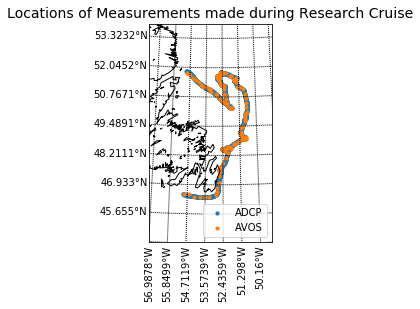

In [23]:
title = 'Locations of Measurements made during Research Cruise'
pads = 2
labels = ['ADCP', 'AVOS']
map_kwargs = {'pads': pads}
sizes = 10
scatter_kwargs = {}
legend_kwargs = {'loc': 4}

kwargs = {'labels': labels,
          'title': title, 'sizes': sizes,
          'map_kwargs': map_kwargs,
          'scatter_kwargs': scatter_kwargs, 
          'legend_kwargs': legend_kwargs}

fig, ax = plot.plot_track([adcp_ds_subset.latitude.values, adcp_ds_subset.longitude.values],
                          [avos_ds_subset['latitude'].values, avos_ds_subset['longitude'].values], **kwargs)
fig.savefig(plot_dir + 'adcp_avos_location.png')

# Histograms

In [24]:
class ComparativeVectorAnalysis:
    
    def __init__(self, u1, v1, u2, v2):
        
        self.u1 = u1
        self.v1 = v1
        self.u2 = u2
        self.v2 = v2
        
        self.w1 = magnitude(u1, v1)
        self.θ1 = direction(u1, v1)
        self.w2 = magnitude(u2, v2)
        self.θ2 = direction(u2, v2)
        
        self.du = self.u2 - self.u1
        self.dv = self.v2 - self.v1
        self.dw = self.w2 - self.w1
        self.dθ = self.θ2 - self.θ1
        
        self.u1_mean = mean(u1)
        self.v1_mean = mean(v1)
        self.w1_mean = mean(self.w1)
        self.θ1_mean = mean(self.θ1)
        self.u2_mean = mean(u2)
        self.v2_mean = mean(v2)
        self.w2_mean = mean(self.w2)
        self.θ2_mean = mean(self.θ2)
        
        self.u1_std = std(u1)
        self.v1_std = std(v1)
        self.w1_std = std(self.w1)
        self.θ1_std = std(self.θ1)
        self.u2_std = std(u2)
        self.v2_std = std(v2)
        self.w2_std = std(self.w2)
        self.θ2_std = std(self.θ2)
        
    def uv_stats(self):
        
        index = ['u1, u2', 'v1, v2', 'w1, w2', 'θ1, θ2']
        data = {'mean': [np.round((self.u1_mean, self.u2_mean), 3), np.round((self.v1_mean, self.v2_mean), 3), 
                         np.round((self.w1_mean, self.w2_mean), 3), np.round((self.θ1_mean, self.θ2_mean), 3)],
                'std': [np.round((self.u1_std, self.u2_std), 3), np.round((self.v1_std, self.v2_std), 3), 
                         np.round((self.w1_std, self.w2_std), 3), np.round((self.θ1_std, self.θ2_std), 3)]}
        
        return pd.DataFrame(data, index=index).T
            
    def plot_du_vs_dv(self):
        
        x = self.u2 - self.u1
        y = self.v2 - self.v1
        fit = np.polyfit(x, y, 1)
        m, b = np.round(fit, 2)
        plt.scatter(x, y)
        plt.plot(np.unique(x), np.poly1d(fit)(np.unique(x)), label=f'slope = {m}\n y-int = {b}', color='black')
        plt.xlabel('DU (m/s)')
        plt.ylabel('DV (m/s)')
        plt.title('Velocity Difference Between Datasets')
        plt.legend()
        plt.show()
        
    def plot_hists(self):
        
        u1 = self.u1
        u2 = self.u2
        v1 = self.v1
        v2 = self.v2
        
        fig = plt.figure(figsize=(6, 6))
        plt.subplot(2, 2, 1)
        plt.hist(alg1(u1, v1, u2, v2))
        plt.title('Algorithm 1 - Speed')
        plt.subplot(2, 2, 2)
        plt.hist(alg2(u1, v1, u2, v2))
        plt.title('Algorithm 2 - Speed')
        plt.subplot(2, 2, 3)
        plt.hist(alg3(u1, v1, u2, v2))
        plt.title('Algorithm 3 - Direction')
        plt.subplot(2, 2, 4)
        plt.hist(alg4(u1, v1, u2, v2))
        plt.title('Algorithm 4 - Direction')
        fig.tight_layout()
        plt.show()
        
def mean(v):
    return np.mean(v)

def std(v):
    return np.std(v)

def magnitude(u, v):
    return np.sqrt(u**2 + v**2)

def direction(u, v):
    return (np.rad2deg(np.arctan2(v, u)) + 360) % 360

def unit_vector(v):
    """ Returns the unit vector of the vector.  """
    return v / np.linalg.norm(v)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    return np.arccos(np.clip(np.dot(unit_vector(v1), unit_vector(v2)), -1.0, 1.0))

def alg1(u1, v1, u2, v2):

    w1 = np.sqrt(u1**2 + v1**2)
    w2 = np.sqrt(u2**2 + v2**2)

    return w2 - w1

def alg2(u1, v1, u2, v2):

    du = u2 - u1
    dv = v2 - v1

    return np.sqrt(du**2 + dv**2)

def alg3(u1, v1, u2, v2):

    d1 = np.rad2deg(np.arctan2(u1, v1))
    d2 = np.rad2deg(np.arctan2(u2, v2))  
    dd = 180 - abs(abs(d1 - d2) - 180)

    return dd

def alg4(u1, v1, u2, v2):

    du = u2 - u1
    dv = v2 - v1
    dd = np.arctan2(dv, du)

    return np.rad2deg(dd)

In [25]:
U1 = avos_ds_subset.eastward_velocity.values
V1 = avos_ds_subset.northward_velocity.values
U2 = narr_atm_df.iu.values
V2 = narr_atm_df.iv.values
wind_analysis = ComparativeVectorAnalysis(U1, V1, U2, V2)

In [28]:
mu, sigma_1, sigma_2, alpha = fit_bivariate_normal(U2 - U1, V2 - V1)
bivariate_normal(mu, sigma_1, sigma_2, alpha)

array([ 0.83343623, -5.99654663])

In [29]:
fit_bivariate_normal(U2 - U1, V2 - V1)

([4.830874416867884, 0.7319703795914418],
 6.792599938118684,
 5.317590178194657,
 -0.45788678689115525)

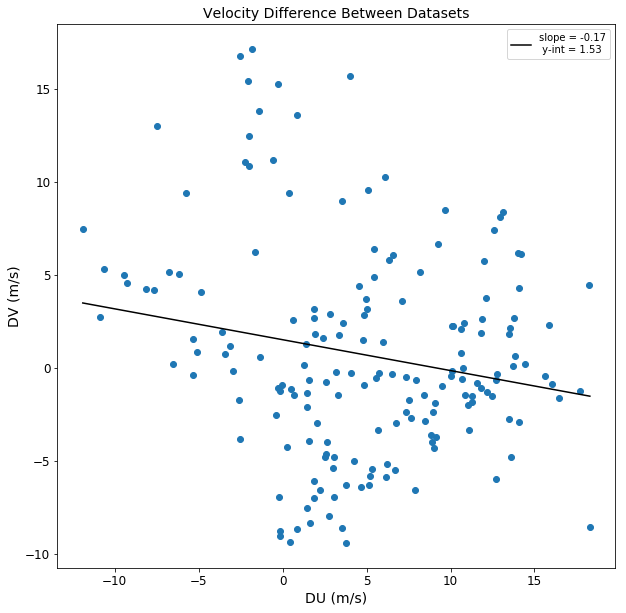

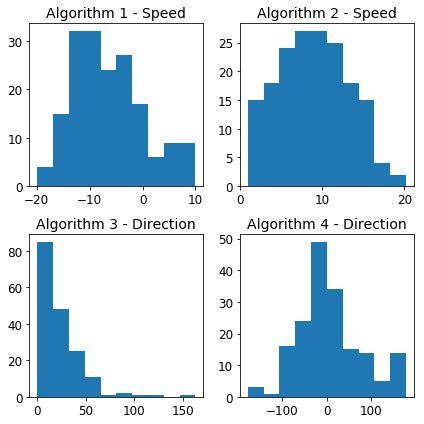

In [30]:
wind_analysis.plot_du_vs_dv()
wind_analysis.plot_hists()

In [31]:
wind_analysis.uv_stats()

,"u1, u2","v1, v2","w1, w2","θ1, θ2"
mean,"[-6.431, -1.601]","[-4.711, -3.979]","[12.8, 6.336]","[223.771, 231.604]"
std,"[9.12, 3.53]","[7.841, 4.385]","[6.662, 3.152]","[63.26, 49.584]"


In [32]:
U1 = ecmwf_ocean_df.u.values
V1 = ecmwf_ocean_df.v.values
U2 = ecmwf_ocean_df.iu.values
V2 = ecmwf_ocean_df.iv.values
current_analysis = ComparativeVectorAnalysis(U1, V1, U2, V2)

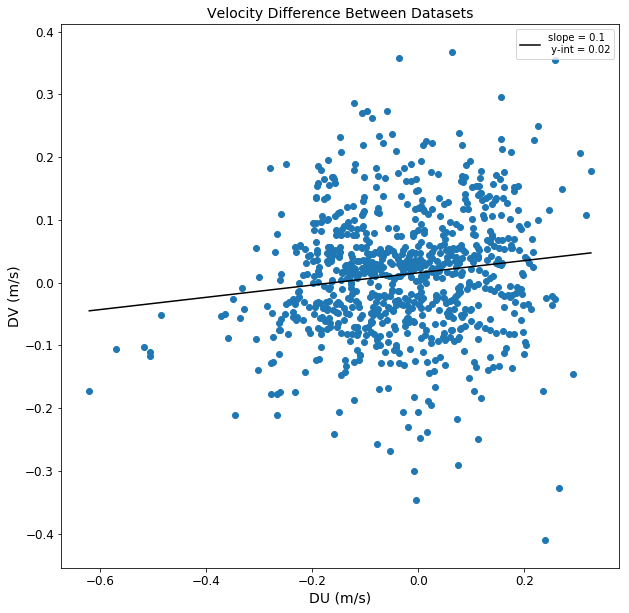

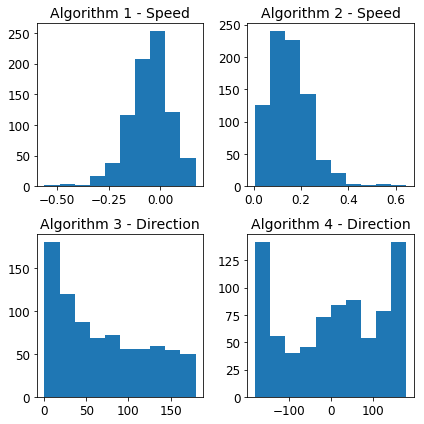

In [33]:
current_analysis.plot_du_vs_dv()
current_analysis.plot_hists()

In [34]:
current_analysis.uv_stats()

,"u1, u2","v1, v2","w1, w2","θ1, θ2"
mean,"[0.051, 0.02]","[-0.009, 0.004]","[0.16, 0.108]","[199.464, 182.823]"
std,"[0.145, 0.089]","[0.102, 0.074]","[0.093, 0.047]","[116.612, 109.95]"


In [49]:
def get_bivariate_distribution(ds, field, time_bounds, latitude_bounds, longitude_bounds):
    
    bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}
    sub_ds = subset_ds(ds, bounds_by_colname)    
    df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
        
    for i in range(len(sub_ds.time.values)):
        
        t = sub_ds.time.values[i]
        x = sub_ds.longitude.values[i]
        y = sub_ds.latitude.values[i]
        
        if len(sub_ds.eastward_velocity.shape) == 2:
            u = sub_ds.eastward_velocity.values[i, 0]
            v = sub_ds.northward_velocity.values[i, 0]
            
        else:
            u = sub_ds.eastward_velocity.values[i]
            v = sub_ds.northward_velocity.values[i]
            
        if np.isfinite(u):
            if np.isfinite(v):
                iu, iv = field.interpolate((t, y, x))
                df.loc[len(df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

    U1 = df.u.values
    V1 = df.v.values
    U2 = df.iu.values
    V2 = df.iv.values
    
    return fit_bivariate_normal(U2 - U1, V2 - V1)

In [50]:
start_time = np.datetime64(min(stats_df['start_time'])) - np.timedelta64(10, 'D')
end_time = np.datetime64(max(stats_df['start_time'])) + np.timedelta64(10, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

In [51]:
get_bivariate_distribution(adcp_ds, metocean.Ocean(time_bounds).current, time_bounds, latitude_bounds, longitude_bounds)

([-0.030926678548224052, 0.01264596568056077],
 0.14013853473630547,
 0.09848249771882077,
 0.19383806680246585)

In [52]:
get_bivariate_distribution(avos_ds, metocean.Atmosphere(time_bounds).wind, time_bounds, latitude_bounds, longitude_bounds)

Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150413.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150414.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150415.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150505.nc... done.


([4.830874416867884, 0.7319703795914418],
 6.792599938118684,
 5.317590178194657,
 -0.45788678689115525)